## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:

from google.colab import files
uploaded = files.upload()


Saving complaints-2021-05-14_08_16.json to complaints-2021-05-14_08_16.json


In [4]:
# Opening JSON file
#f = # Write the path to your data file and load it

# get file name
filename = list(uploaded.keys())[0] #as uploaded files are stored in dict and keys are filenames and values are raw file contents

with open(filename,'r') as f:
    data = json.load(f)

# returns JSON object as
# a dictionary

df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.

df.head(3)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


In [6]:
print("Shape of DataFrame:", df.shape)

Shape of DataFrame: (78313, 22)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
df.isnull().sum()

,0
_index,0
_type,0
_id,0
_score,0
_source.tags,67413
_source.zip_code,6757
_source.complaint_id,0
_source.issue,0
_source.date_received,0
_source.state,1991


In [9]:
#print the column names

print("Columns in DataFrame:", df.columns)

Columns in DataFrame: Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [10]:
#Assign new column names

df.columns = [col.replace('_source.', '') for col in df.columns]
df.rename(columns={'_index': 'index','_type': 'type','_id': 'id','_score': 'score'}, inplace=True)

print("Columns in DataFrame:", df.columns)

Columns in DataFrame: Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [11]:
(df['complaint_what_happened'] == '').sum()

np.int64(57241)

In [12]:
#Assign nan in place of blanks in the complaints column

print("Blanks before replacement:", (df['complaint_what_happened'] == '').sum())
df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan)
print("NaNs after replacement:", df['complaint_what_happened'].isna().sum())



Blanks before replacement: 57241
NaNs after replacement: 57241


In [13]:
#Remove all rows where complaints column is nan

rows_before = df.shape[0]
df.dropna(subset=['complaint_what_happened'], inplace=True)
rows_after = df.shape[0]

print(f"Rows removed: {rows_before - rows_after}")
print(f"Rows remaining: {rows_after}")

Rows removed: 57241
Rows remaining: 21072


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)     # ? as we don't want to remove everything btw first '[' and last ']'
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text


In [15]:
#Write your function to Lemmatize the texts
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct]
    return " ".join(lemmas)


In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

df['clean_complaints'] = df['complaint_what_happened'].apply(clean_text)

df['lemmatized_complaints'] = df['clean_complaints'].apply(lemmatize)

df_clean = df[['complaint_what_happened','clean_complaints', 'lemmatized_complaints']].copy()
df_clean.head(3)

,complaint_what_happened,clean_complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...


In [17]:
df_clean.head(3)

,complaint_what_happened,clean_complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...


In [18]:
#Write your function to extract the POS tags

def pos_tag(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if token.pos_ == "NOUN"])

df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].apply(pos_tag)   #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

df_clean = df_clean[['complaint_what_happened', 'lemmatized_complaints', 'complaint_POS_removed']]

df_clean.head()


,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




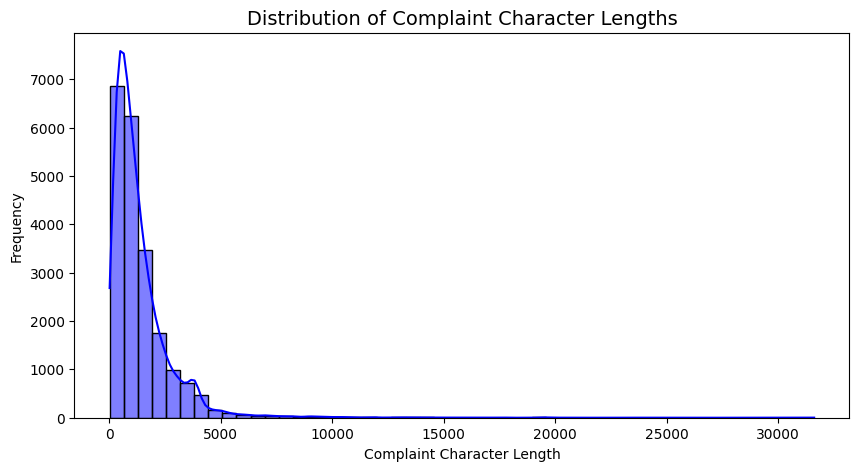

In [20]:
# Write your code here to visualise the data according to the 'Complaint' character length


df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()


plt.figure(figsize=(10,5))
sns.histplot(df_clean['complaint_length'], bins=50, kde=True, color='blue')
plt.title("Distribution of Complaint Character Lengths", fontsize=14)
plt.xlabel("Complaint Character Length")
plt.ylabel("Frequency")
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

In [21]:
!pip install wordcloud

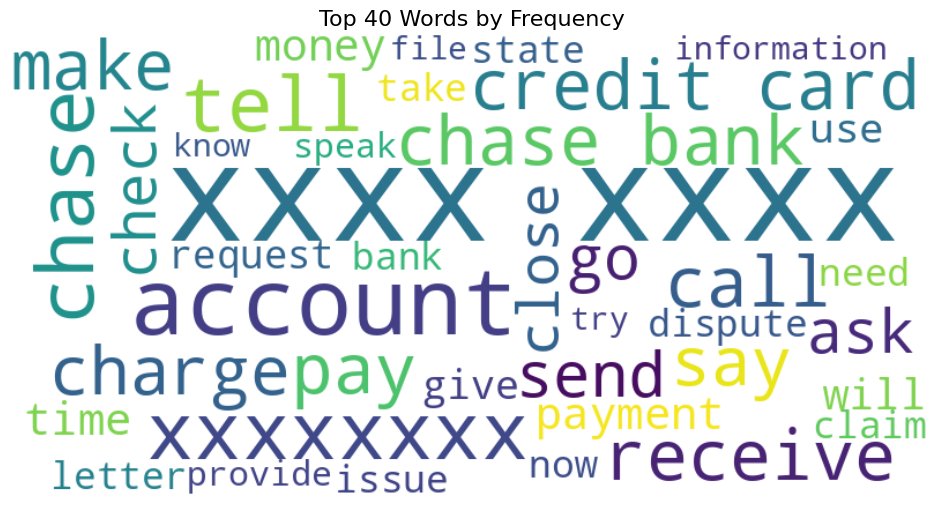

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

all_words = " ".join(df_clean['lemmatized_complaints'])

wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white',colormap='viridis').generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 40 Words by Frequency", fontsize=16)
plt.show()


In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '',  regex=False)

In [24]:
# def pos_tag(text):
#   doc = nlp(text)
#   return " ".join([token.lemma_ for token in doc if token.pos_ == "NOUN" and token.lemma_ != '-PRON-'])

# df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaint'].swifter.apply(pos_tag)

In [25]:
df_clean.head(2)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_clean['complaint_what_happened'].fillna(""))

words = vectorizer.get_feature_names_out()
frequencies = X.toarray().sum(axis=0) # adds each rows for all columns

word_freq = list(zip(words, frequencies))

top_30_unigrams = sorted(word_freq, key=lambda x: x[1], reverse=True)[:30]

for word, freq in top_30_unigrams:
    print(f"{word}: {freq}")


xxxx: 228998
chase: 80810
xx: 77015
account: 42745
credit: 32806
00: 30482
card: 26941
bank: 26760
told: 16383
did: 16005
payment: 14123
called: 13474
received: 12876
time: 12223
money: 11990
said: 10891
loan: 10076
check: 9792
information: 9682
letter: 8462
sent: 8347
mortgage: 7980
pay: 7980
number: 7777
days: 7563
phone: 7528
asked: 7459
report: 7388
payments: 7243
balance: 7218


In [27]:

# vectorizer = CountVectorizer(stop_words='english')
# X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

# sum_words = X.sum(axis=0)
# words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
# words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# unigram_df = pd.DataFrame(words_freq, columns=['word', 'count'])
# print(unigram_df.head(30))


In [28]:
#Print the top 10 words in the unigram frequency

top_10_unigrams = sorted(word_freq, key=lambda x: x[1], reverse=True)[:10]


for word, freq in top_10_unigrams:
    print(f"{word}: {freq}")


xxxx: 228998
chase: 80810
xx: 77015
account: 42745
credit: 32806
00: 30482
card: 26941
bank: 26760
told: 16383
did: 16005


In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2))

X_bigram = bigram_vectorizer.fit_transform(df_clean['complaint_what_happened'].fillna(""))

bigrams = bigram_vectorizer.get_feature_names_out()

frequencies_bigram = X_bigram.toarray().sum(axis=0)

bigram_freq = list(zip(bigrams, frequencies_bigram))

top_30_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:30]

for bigram, freq in top_30_bigrams:
    print(f"{bigram}: {freq}")


xxxx xxxx: 90158
xx xx: 38193
xx xxxx: 28157
chase bank: 12725
credit card: 10947
xxxx xx: 5994
xxxx chase: 5132
called chase: 3699
checking account: 3568
credit report: 3248
customer service: 3021
chase xxxx: 2976
xx 2020: 2861
jp morgan: 2714
morgan chase: 2566
chase credit: 2392
00 xxxx: 2379
account xxxx: 2360
xx 2019: 2148
xxxx received: 2139
account chase: 1959
debit card: 1959
xxxx account: 1952
credit cards: 1895
xx 2018: 1862
xxxx called: 1809
contacted chase: 1737
xxxx credit: 1734
bank account: 1710
number xxxx: 1707


In [30]:
#Print the top 10 words in the bigram frequency

top_10_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:10]

for bigram, freq in top_30_bigrams:
    print(f"{bigram}: {freq}")


xxxx xxxx: 90158
xx xx: 38193
xx xxxx: 28157
chase bank: 12725
credit card: 10947
xxxx xx: 5994
xxxx chase: 5132
called chase: 3699
checking account: 3568
credit report: 3248
customer service: 3021
chase xxxx: 2976
xx 2020: 2861
jp morgan: 2714
morgan chase: 2566
chase credit: 2392
00 xxxx: 2379
account xxxx: 2360
xx 2019: 2148
xxxx received: 2139
account chase: 1959
debit card: 1959
xxxx account: 1952
credit cards: 1895
xx 2018: 1862
xxxx called: 1809
contacted chase: 1737
xxxx credit: 1734
bank account: 1710
number xxxx: 1707


In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).

from sklearn.feature_extraction.text import CountVectorizer

trigram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))

X_trigram = trigram_vectorizer.fit_transform(df_clean['complaint_what_happened'].fillna(""))

trigrams = trigram_vectorizer.get_feature_names_out()

frequencies_trigram = X_trigram.toarray().sum(axis=0)

trigram_freq = list(zip(trigrams, frequencies_trigram))

top_30_trigrams = sorted(trigram_freq, key=lambda x: x[1], reverse=True)[:30]

for bigram, freq in top_30_trigrams:
    print(f"{bigram}: {freq}")

xxxx xxxx xxxx: 42037
xx xx xxxx: 27747
xxxx xx xx: 5987
xx xx 2020: 2853
xx xxxx xxxx: 2787
xx xxxx xx: 2531
jp morgan chase: 2229
xx xx 2019: 2127
xx xx 2018: 1851
chase credit card: 1828
xxxx xxxx xx: 1672
xxxx xxxx chase: 1638
00 xx xx: 1477
xx xxxx chase: 1298
chase xxxx xxxx: 1240
00 xxxx xxxx: 1158
xx xxxx received: 1118
chase bank xxxx: 1005
account xx xx: 970
account xxxx xxxx: 947
chase xx xx: 906
bank xxxx xxxx: 877
xxxx xxxx 2016: 843
dated xx xx: 831
xxxx credit card: 789
xxxx chase bank: 783
credit card company: 777
xxxx xxxx account: 753
xxxx xxxx 2015: 714
morgan chase bank: 693


In [32]:
#Print the top 10 words in the trigram frequency


top_30_trigrams = sorted(trigram_freq, key=lambda x: x[1], reverse=True)[:10]

for trigram, freq in top_30_trigrams:
    print(f"{trigram}: {freq}")

xxxx xxxx xxxx: 42037
xx xx xxxx: 27747
xxxx xx xx: 5987
xx xx 2020: 2853
xx xxxx xxxx: 2787
xx xxxx xx: 2531
jp morgan chase: 2229
xx xx 2019: 2127
xx xx 2018: 1851
chase credit card: 1828


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace(r'\b[xX]+\b', '', regex=True)

In [34]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...,224,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,2114,credit card provider claim purchase protection...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,2319,pay risk consumer chase bank app chase year ba...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,2171,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

dtm = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'].fillna(""))

dtm_df = pd.DataFrame(dtm.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(dtm_df.head())


    aa  aarp   ab  abandonment  abatement  abbreviation  abet  abide  ability  \
0  0.0   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
1  0.0   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
2  0.0   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
3  0.0   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
4  0.0   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   

   abovementione  ...  yoga  youinv  youth   yr  yrs  zap  zip  zipcode  \
0            0.0  ...   0.0     0.0    0.0  0.0  0.0  0.0  0.0      0.0   
1            0.0  ...   0.0     0.0    0.0  0.0  0.0  0.0  0.0      0.0   
2            0.0  ...   0.0     0.0    0.0  0.0  0.0  0.0  0.0      0.0   
3            0.0  ...   0.0     0.0    0.0  0.0  0.0  0.0  0.0      0.0   
4            0.0  ...   0.0     0.0    0.0  0.0  0.0  0.0  0.0      0.0   

   zombie  zone  
0     0.0   0.0  
1     0.0   0.0  
2     0.

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



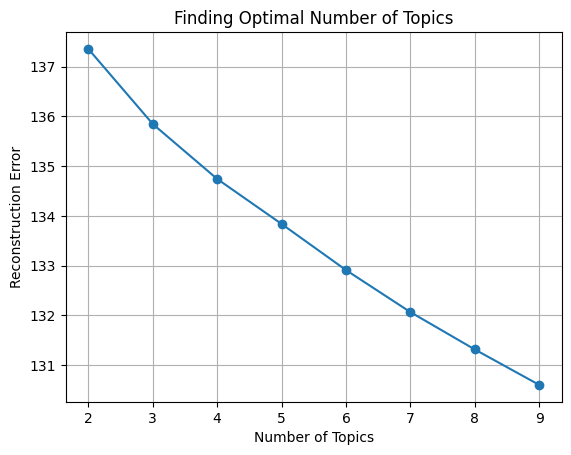

In [38]:

errors = []
topic_range = range(2, 10)

for n_topics in topic_range:
    nmf_model = NMF(n_components=n_topics, random_state=40)
    W = nmf_model.fit_transform(dtm)
    H = nmf_model.components_
    errors.append(nmf_model.reconstruction_err_)

plt.plot(topic_range, errors, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.title("Finding Optimal Number of Topics")
plt.grid(True)
plt.show()


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [39]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
#write your code here
nmf_model = NMF(n_components=num_topics, random_state=40)
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_


In [40]:
nmf_model.fit(dtm)
len(tfidf_vectorizer.get_feature_names_out())


6929

In [41]:
#Print the Top15 words for each of the topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"\nTopic #{topic_idx + 1}:")
    top_indices = topic.argsort()[::-1][:15]
    top_words = [feature_names[i] for i in top_indices]
    print(", ".join(top_words))


Topic #1:
account, check, bank, money, chase, fund, deposit, branch, day, checking, number, business, transaction, transfer, customer

Topic #2:
credit, card, report, inquiry, chase, account, score, company, debt, limit, information, application, letter, year, reporting

Topic #3:
loan, mortgage, chase, home, modification, property, year, letter, document, rate, time, foreclosure, house, sale, request

Topic #4:
charge, card, chase, fee, transaction, dispute, merchant, purchase, fraud, claim, service, time, statement, email, refund

Topic #5:
payment, balance, month, fee, statement, day, time, auto, chase, date, credit, account, mortgage, year, error


In [42]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(dtm)

In [43]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1) #write your code to assign topics to each rows.

In [44]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...,224,chase card report application identity consent...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0


In [45]:
df_clean.shape

(21072, 6)

In [46]:
df_clean1 = df_clean.copy()


In [47]:
df_clean1


,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...,224,chase card report application identity consent...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...,3
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,2114,credit card provider claim purchase protection...,3
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,2319,pay risk consumer chase bank app chase year ba...,3
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,2171,credit yrs chase credit card chase freedom pro...,4


In [48]:
df_clean_top5 = (
    df_clean.sort_values(['Topic'])
            .groupby('Topic')
            .head(5)

)

print(df_clean_top5[['Topic', 'Complaint_clean']])

       Topic                                    Complaint_clean
43246      0  fire loss payment deposit account chase branch...
43245      0  camera equipment website invoice company wire ...
131        0  check deposit deposit deposit day bank coupon ...
115        0  time  chase order credit debit account fee rec...
111        0  chase billing error good service chase claim d...
26         1  time attempt inquiry remove creditor inquiry r...
23         1  chase credit card report datum credit report c...
15         1                                            inquiry
11         1  ticket offer ticket reward card information of...
10         1  chase card report application identity consent...
78293      2  attorney debt file bankruptcy copy cease lette...
78283      2  attempt document loan file line credit agreeme...
1          2  morning name stop service debt verification st...
78249      2  heloc failure notary signing document bank man...
78246      2  cfpb mortgage loan bank is

In [49]:
# # #Print the first 5 Complaint for each of the Topics
# df_clean1=df_clean1.groupby('Topic').head(5)
# df_clean1.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [50]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Banking Access Issues',
    1: 'Credit Card or prepaid card',
    2: 'Theft/Dispute Reporting',
    3: 'Mortgage/Loan',
    4: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)
#df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)


In [51]:
print(df_clean['Topic'].unique())

['Theft/Dispute Reporting' 'Mortgage/Loan' 'Credit Card or prepaid card'
 'Banking Access Issues' 'Others']


In [52]:
df_clean.head(10)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...,Theft/Dispute Reporting
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...,Mortgage/Loan
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...,224,chase card report application identity consent...,Credit Card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...,Credit Card or prepaid card
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,Banking Access Issues
15,Can you please remove inquiry,can you please remove inquiry,inquiry,29,inquiry,Credit Card or prepaid card
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,notice jp account debit card branch customer s...,2277,notice jp account debit card branch customer s...,Banking Access Issues
20,"During the summer months, I experience a decli...",during the summer month I experience a decline...,summer month decline income employment month p...,1396,summer month decline income employment month p...,Others
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx I make a payment to an online reta...,payment retailer use chase pay chase website s...,3541,payment retailer use chase pay chase website s...,Mortgage/Loan
23,I have a Chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card report datum credit report c...,129,chase credit card report datum credit report c...,Credit Card or prepaid card


In [53]:
df_clean.shape

(21072, 6)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [54]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Banking Access Issues': 0,
    'Credit Card or prepaid card': 1,
    'Theft/Dispute Reporting': 2,
    'Mortgage/Loan': 3,
    'Others': 4
}

# Topic_names_numeric = {v: k for k, v in Topic_names.items()}

df_clean['Topic_numeric'] = df_clean['Topic'].map(Topic_names)



In [55]:
df_clean.head(3)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic,Topic_numeric
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...,Theft/Dispute Reporting,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...,Mortgage/Loan,3
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...,224,chase card report application identity consent...,Credit Card or prepaid card,1


In [56]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic_numeric']]

In [57]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [58]:

# #Write your code to get the Vector count

# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.model_selection import train_test_split

# count_vect = CountVectorizer(stop_words='english')
# X_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

# #Write your code here to transform the word vector to tf-idf

# tfidf_transformer = TfidfTransformer()
# X_tfidf = tfidf_transformer.fit_transform(X_counts)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_tfidf, training_data['Topic_numeric'], test_size=0.2, random_state=42, stratify=training_data['Topic_numeric']
# )

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    training_data['complaint_what_happened'], training_data['Topic_numeric'],
    test_size=0.2, random_state=42
)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [60]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))






Logistic Regression:
Accuracy: 0.9200474495848161
Precision: 0.9204868643756676
Recall: 0.9200474495848161
F1 score: 0.9200317169533423


In [61]:
# try Decision Tree
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.7850533807829182
Precision: 0.7848988351756483
Recall: 0.7850533807829182
F1 score: 0.7848383954133116


In [62]:
# try Random forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.8377224199288256
Precision: 0.8414035906200863
Recall: 0.8377224199288256
F1 score: 0.8332026702494655


In [63]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("\nNaive Bayes:")
# print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred_nb, average='weighted'))


Naive Bayes:
Accuracy: 0.7610913404507711
Precision: 0.7861160110402096
Recall: 0.7610913404507711
F1 score: 0.7399334998835169


In [64]:
# # Write your code here to build any 3 models and evaluate them using the required metrics

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import classification_report, accuracy_score

# # Logistic Regression
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train, y_train)
# y_pred_lr = lr.predict(X_test)
# print("Logistic Regression:")
# print(classification_report(y_test, y_pred_lr))
# print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# # Decision Tree
# dt = DecisionTreeClassifier(random_state=42)
# dt.fit(X_train, y_train)
# y_pred_dt = dt.predict(X_test)
# print("\nDecision Tree:")
# print(classification_report(y_test, y_pred_dt))
# print("Accuracy:", accuracy_score(y_test, y_pred_dt))

# # Random Forest
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)
# print("\nRandom Forest:")
# print(classification_report(y_test, y_pred_rf))
# print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# # Naive Bayes (optional)
# nb = MultinomialNB()
# nb.fit(X_train, y_train)
# y_pred_nb = nb.predict(X_test)
# print("\nNaive Bayes:")
# print(classification_report(y_test, y_pred_nb))
# print("Accuracy:", accuracy_score(y_test, y_pred_nb))


